In [1]:
import numpy as np
from cmdstanpy import CmdStanModel
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import beta

1. generate 10 samples from bernoulli distribution with theta = 0.3

In [2]:
theta = 0.3
N = 11
np.random.seed(12345)
samples = np.random.binomial(1, theta, N)
y = samples
print(samples)

[1 0 0 0 0 0 1 0 1 0 1]


In [3]:
# maximum likelihood estimation
theta_hat = np.mean(samples)
print(theta_hat)

0.36363636363636365


0.38461538461538464 0.36363636363636365


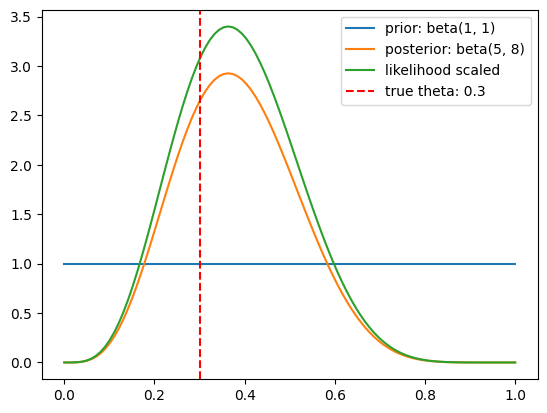

In [4]:
alpha_prior = 1
beta_prior = 1
alpha_post = alpha_prior + np.sum(y)
beta_post = beta_prior + N - np.sum(y)
theta_post = alpha_post / (alpha_post + beta_post)  # posterior mean
theta_map = (alpha_post - 1) / (alpha_post + beta_post - 2)  # posterior mode
print(theta_post, theta_map)

th = np.linspace(0, 1, 100) # theta values
likelihood = th**np.sum(y) * (1-th)**(N-np.sum(y)) # likelihood function
likelihood *= 3.4/np.max(likelihood)  # scale up for visualization

pdf_beta_prior = beta.pdf(th, alpha_prior, beta_prior)
pdf_beta_post = beta.pdf(th, alpha_post, beta_post)
plt.plot(th, pdf_beta_prior, label=f'prior: beta({alpha_prior}, {beta_prior})')
plt.plot(th, pdf_beta_post, label=f'posterior: beta({alpha_post}, {beta_post})')
plt.plot(th, likelihood, label='likelihood scaled')
plt.axvline(theta, color='red', linestyle='dashed', label=f'true theta: {theta}')
plt.legend();

0.4 0.38461538461538464


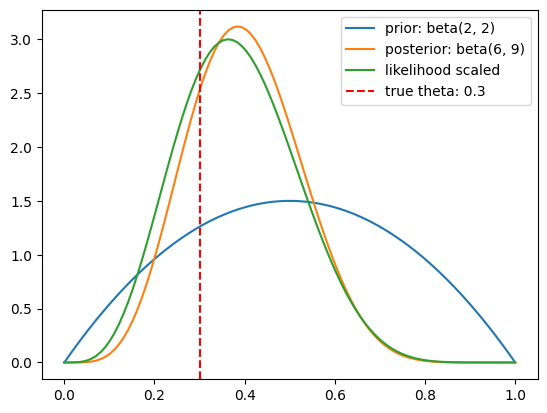

In [5]:
alpha_prior = 2
beta_prior = 2
alpha_post = alpha_prior + np.sum(y)
beta_post = beta_prior + N - np.sum(y)
theta_post = alpha_post / (alpha_post + beta_post)  # posterior mean
theta_map = (alpha_post - 1) / (alpha_post + beta_post - 2)  # posterior mode
print(theta_post, theta_map)



th = np.linspace(0, 1, 100)
likelihood = th**np.sum(y) * (1-th)**(N-np.sum(y))
likelihood *= 3/np.max(likelihood)  # scale up for visualization

pdf_beta_prior = beta.pdf(th, alpha_prior, beta_prior)
pdf_beta_post = beta.pdf(th, alpha_post, beta_post)
plt.plot(th, pdf_beta_prior, label=f'prior: beta({alpha_prior}, {beta_prior})')
plt.plot(th, pdf_beta_post, label=f'posterior: beta({alpha_post}, {beta_post})')
plt.plot(th, likelihood, label='likelihood scaled')
plt.axvline(theta, color='red', linestyle='dashed', label=f'true theta: {theta}')
plt.legend();

0.42857142857142855 0.42105263157894735


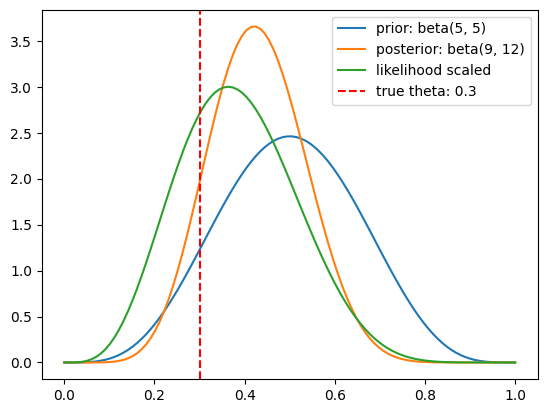

In [6]:
alpha_prior = 5
beta_prior = 5
alpha_post = alpha_prior + np.sum(y)
beta_post = beta_prior + N - np.sum(y)
theta_post = alpha_post / (alpha_post + beta_post)  # posterior mean
theta_map = (alpha_post - 1) / (alpha_post + beta_post - 2)  # posterior mode
print(theta_post, theta_map)



th = np.linspace(0, 1, 100)
likelihood = th**np.sum(y) * (1-th)**(N-np.sum(y))
likelihood *= 3/np.max(likelihood)  # scale up for visualization

pdf_beta_prior = beta.pdf(th, alpha_prior, beta_prior)
pdf_beta_post = beta.pdf(th, alpha_post, beta_post)
plt.plot(th, pdf_beta_prior, label=f'prior: beta({alpha_prior}, {beta_prior})')
plt.plot(th, pdf_beta_post, label=f'posterior: beta({alpha_post}, {beta_post})')
plt.plot(th, likelihood, label='likelihood scaled')
plt.axvline(theta, color='red', linestyle='dashed', label=f'true theta: {theta}')
plt.legend();

In [7]:
stan_code = """
data {
    int<lower=0> N;  // number of trials
    array[N] int<lower=0, upper=1> y;  // observed data
    real<lower=0> alpha;  // prior hyperparameter
    real<lower=0> beta;  // prior hyperparameter
}
parameters {
    real<lower=0, upper=1> theta;  // parameter of interest
}
model {
    theta ~ beta(alpha, beta);  // prior distribution
    y ~ bernoulli(theta);  // likelihood
}
"""
import os
dirname = 'stan_files'
os.makedirs(dirname, exist_ok=True)
stan_file = dirname + '/' +'bernoulli.stan'
stan_file = os.path.join(dirname, 'bernoulli.stan')
print(stan_file)
with open(stan_file, 'w') as f:
    f.write(stan_code)

stan_files\bernoulli.stan


import cmdstanpy
cmdstanpy.install_cmdstan()
cmdstanpy.install_cmdstan(compiler=True)  # only valid on Windows

In [8]:
from cmdstanpy import CmdStanModel
# Create a CmdStanModel object

model = CmdStanModel(stan_file=stan_file)

09:51:05 - cmdstanpy - INFO - compiling stan file C:\git\KOS6313\stan_files\bernoulli.stan to exe file C:\git\KOS6313\stan_files\bernoulli.exe
09:51:59 - cmdstanpy - INFO - compiled model executable: C:\git\KOS6313\stan_files\bernoulli.exe


In [9]:
# Define the data dictionary
data = {
    'N': N,
    'y': y,
    'alpha': alpha_prior,
    'beta': beta_prior
}

In [10]:
map_estimate = model.optimize(data=data)
map_theta = map_estimate.stan_variable('theta')
print(map_theta, type(map_theta))

09:51:59 - cmdstanpy - INFO - Chain [1] start processing
09:51:59 - cmdstanpy - INFO - Chain [1] done processing
09:51:59 - cmdstanpy - WARNING - The default behavior of CmdStanMLE.stan_variable() will change in a future release to always return a numpy.ndarray, even for scalar variables.


0.421068 <class 'float'>


In [11]:
# Sample from the posterior distribution by MCMC
fit = model.sample(data=data, chains=4, iter_sampling=1000, iter_warmup=500)

# Extract the samples for theta
theta_samples = fit.stan_variable('theta')

# Print the summary of the fit
print(fit.summary())

09:51:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

09:52:00 - cmdstanpy - INFO - CmdStan done processing.



            Mean     MCSE    StdDev       MAD         5%        50%  \
lp__  -14.835000  0.01582  0.676096  0.310753 -16.192700 -14.567400   
theta   0.430502  0.00282  0.103895  0.106681   0.264577   0.428078   

             95%  ESS_bulk  ESS_tail    R_hat  
lp__  -14.343200   2033.94   2397.54  1.00035  
theta   0.604814   1353.29   2013.13  1.00360  


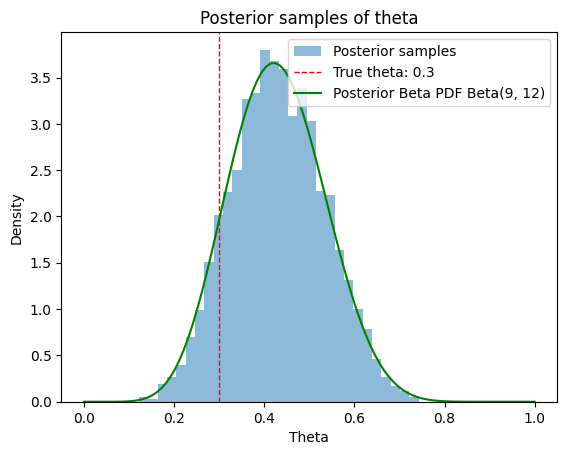

In [12]:
# Plot the histogram of the samples
plt.hist(theta_samples, bins=30, density=True, alpha=0.5, label='Posterior samples')
plt.axvline(theta, color='red', linestyle='dashed', linewidth=1, label=f'True theta: {theta}')
plt.plot(th, pdf_beta_post, label=f'Posterior Beta PDF Beta({alpha_post}, {beta_post})', color='green')
plt.title('Posterior samples of theta')
plt.xlabel('Theta')
plt.ylabel('Density')
plt.legend()
plt.show()

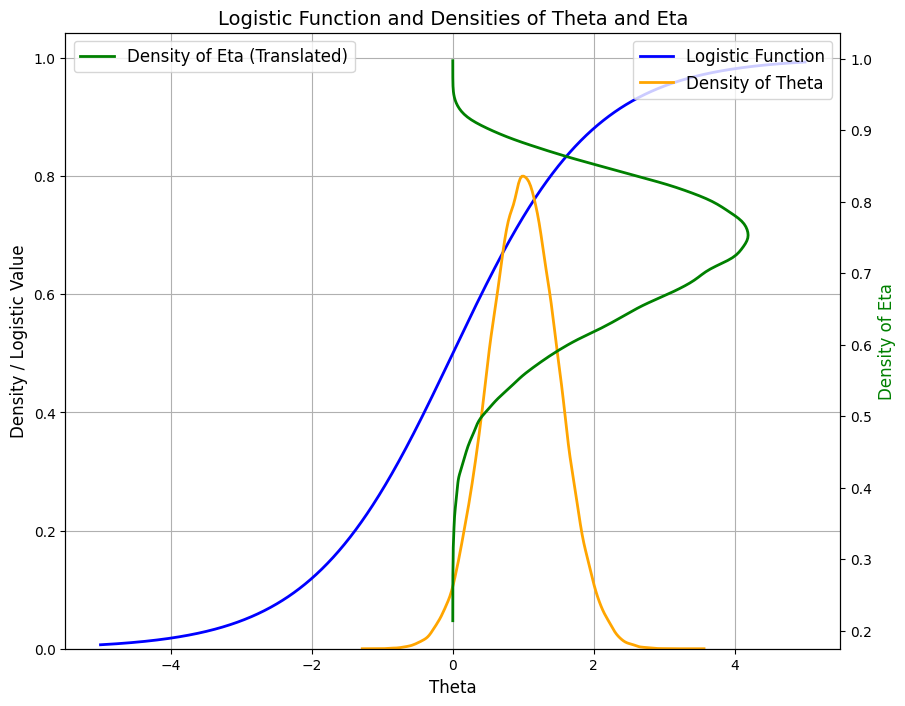

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Draw 1000 samples from a standard normal distribution
theta_samples_standard_normal = np.random.normal(1, .5, 100000)

# Define the logistic function
def logistic(x):
    return 1 / (1 + np.exp(-x))

# Generate a range of theta values for plotting
theta_range = np.linspace(-5, 5, 1000)

# Compute eta values using the logistic function
eta_values = logistic(theta_range)

# Transform theta to eta for density plot
eta_samples_standard_normal = logistic(theta_samples_standard_normal)

# Translate eta density by -5
eta_samples_translated = eta_samples_standard_normal

# Create a single figure
fig, ax1 = plt.subplots(figsize=(10, 8))

# Plot the logistic function and density of theta on the primary x-axis
ax1.plot(theta_range, eta_values, label='Logistic Function', color='blue', linewidth=2)
sns.kdeplot(theta_samples_standard_normal, label='Density of Theta', color='orange', linewidth=2, ax=ax1)

# Add labels and grid for the primary axis
ax1.set_title('Logistic Function and Densities of Theta and Eta', fontsize=14)
ax1.set_xlabel('Theta', fontsize=12)
ax1.set_ylabel('Density / Logistic Value', fontsize=12)
ax1.grid()
ax1.legend(loc='upper right', fontsize=12)

# Create a secondary y-axis for the density of eta
ax2 = ax1.twinx()
sns.kdeplot(y=eta_samples_translated, label='Density of Eta (Translated)', color='green', linewidth=2, ax=ax2)

# Add labels and legend for the secondary axis
ax2.set_ylabel('Density of Eta', fontsize=12, color='green')
ax2.legend(loc='upper left', fontsize=12)

plt.show()


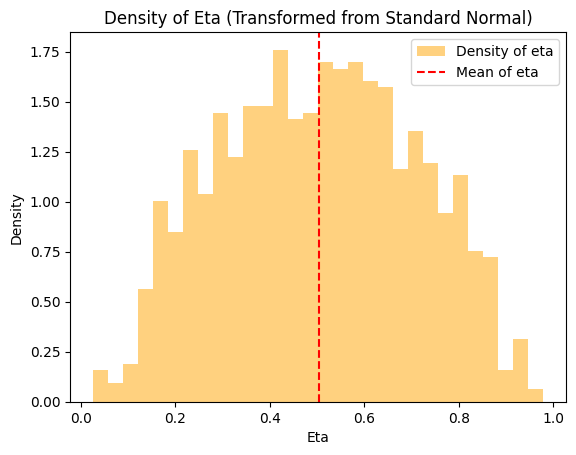

In [ ]:
# Transform theta to eta using the logistic function
eta_samples_standard_normal = 1 / (1 + np.exp(-theta_samples_standard_normal))

# Plot the density of eta
plt.hist(eta_samples_standard_normal, bins=30, density=True, alpha=0.5, color='orange', label='Density of eta')
plt.axvline(np.mean(eta_samples_standard_normal), color='red', linestyle='dashed', label='Mean of eta')
plt.xlabel('Eta')
plt.ylabel('Density')
plt.title('Density of Eta (Transformed from Standard Normal)')
plt.legend()
plt.show()

10:03:41 - cmdstanpy - INFO - compiling stan file C:\git\KOS6313\stan_files\logistic_model.stan to exe file C:\git\KOS6313\stan_files\logistic_model.exe
10:04:03 - cmdstanpy - INFO - compiled model executable: C:\git\KOS6313\stan_files\logistic_model.exe
10:04:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

10:04:04 - cmdstanpy - INFO - CmdStan done processing.



           Mean      MCSE    StdDev       MAD        5%       50%       95%  \
lp__  -7.854480  0.017161  0.721063  0.337336 -9.332410 -7.568550 -7.324940   
theta -0.436516  0.014474  0.546679  0.543045 -1.353390 -0.424322  0.466367   
eta    0.399417  0.003279  0.123211  0.127471  0.205316  0.395483  0.614524   

       ESS_bulk  ESS_tail    R_hat  
lp__    1842.33   2229.93  1.00016  
theta   1446.10   1921.36  1.00211  
eta     1446.10   1921.36  1.00211  


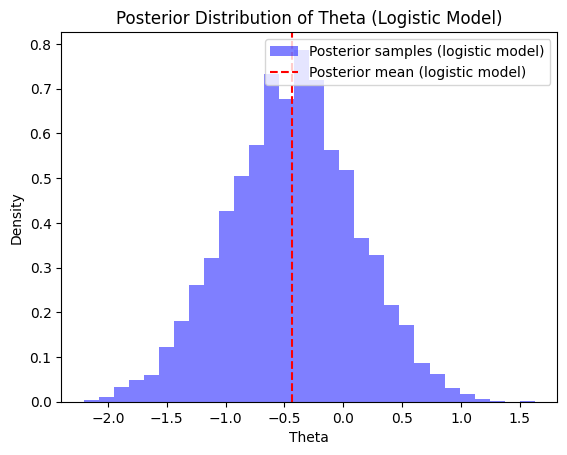

In [13]:
stan_code = """
functions {
    real logistic_function(real x) {
        return 1 / (1 + exp(-x));
    }
}
data {
    int<lower=0> N;  // number of trials
    array[N] int<lower=0, upper=1> y;  // observed data
    real mm;  // mean of normal prior for theta
    real ss;  // standard deviation of normal prior for theta
}
parameters {
    real theta;  // parameter of interest
}
transformed parameters {
    real eta = logistic_function(theta);  // transformed parameter
}
model {
    theta ~ normal(mm, ss);  // prior for theta
    y ~ bernoulli(eta);  // likelihood
}
"""

# Save the new Stan code to a file
stan_file_logistic = os.path.join(dirname, 'logistic_model.stan')
with open(stan_file_logistic, 'w') as f:
    f.write(stan_code)

# Create a CmdStanModel object for the new Stan model
logistic_model = CmdStanModel(stan_file=stan_file_logistic)

# Define the data dictionary for the logistic model
data_logistic = {
    'N': N,
    'y': y,
    'mm': 0,  # mean of normal prior
    'ss': 1   # standard deviation of normal prior
}

# Perform MCMC sampling
fit_logistic = logistic_model.sample(data=data_logistic, chains=4, iter_sampling=1000, iter_warmup=500)

# Extract the samples for theta
theta_samples_logistic = fit_logistic.stan_variable('theta')

# Print the summary of the fit
print(fit_logistic.summary())
# Plot the posterior distribution of theta
plt.hist(theta_samples_logistic, bins=30, density=True, alpha=0.5, color='blue', label='Posterior samples (logistic model)')
plt.axvline(np.mean(theta_samples_logistic), color='red', linestyle='dashed', label='Posterior mean (logistic model)')
plt.xlabel('Theta')
plt.ylabel('Density')
plt.title('Posterior Distribution of Theta (Logistic Model)')
plt.legend()
plt.show()


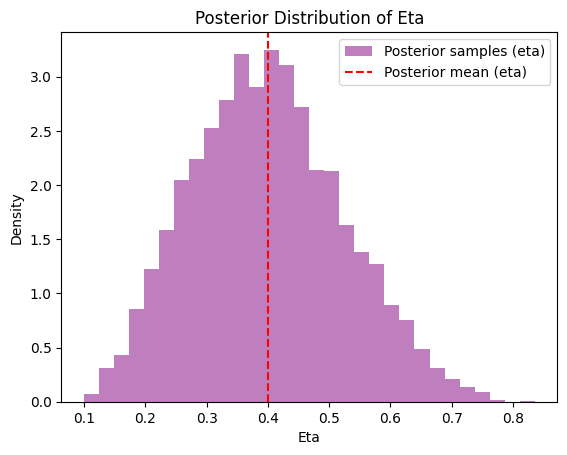

In [14]:
# Transform theta_samples_logistic to eta
eta_samples = 1 / (1 + np.exp(-theta_samples_logistic))

# Plot the density of eta
plt.hist(eta_samples, bins=30, density=True, alpha=0.5, color='purple', label='Posterior samples (eta)')
plt.axvline(np.mean(eta_samples), color='red', linestyle='dashed', label='Posterior mean (eta)')
plt.xlabel('Eta')
plt.ylabel('Density')
plt.title('Posterior Distribution of Eta')
plt.legend()
plt.show()